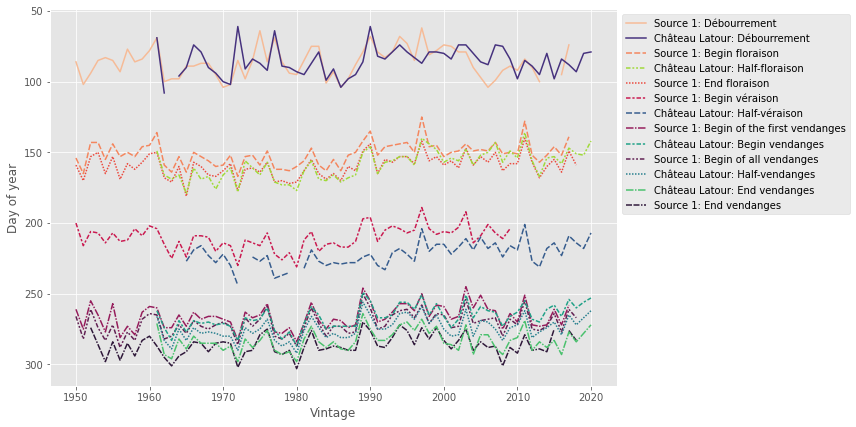

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16, 5)

pheno_1 = pd.read_excel('data/pheno/pheno_TL.xlsx', index_col=0).rename(columns=
            {
                'Pousse de la vigne':'Source 1: Débourrement',
                'Première fleur':'Source 1: Begin floraison',
                'Pleine fleur':'Source 1: End floraison',
                'Premiers grains changés':'Source 1: Begin véraison',
                'Début vendanges (en Médoc)':'Source 1: Begin of the first vendanges',
                'Pleines vendanges':'Source 1: Begin of all vendanges',
                'Fin vendanges rouges':'Source 1: End vendanges',
            })
pheno_1 = pheno_1.iloc[:, :7]
cols = list(pheno_1.columns)
years = list(pheno_1.index)
pheno_1_plot = pheno_1.copy()

for col in cols:
    pheno_1[col] = pd.to_datetime(pheno_1[col], errors='coerce')
    for year in years:
        try:
            pheno_1.loc[year, col] = pheno_1.loc[year, col].replace(year = year).normalize()
        except:
            continue
    pheno_1_plot[col] = pheno_1[col].dt.dayofyear

plt.figure(figsize=(12,6))
palette = sns.color_palette('rocket_r', 7)
sns.lineplot(data = pheno_1_plot, palette = palette)
    
pheno_2 = pd.read_excel('data/pheno/pheno_latour.xlsx', index_col=0).rename(columns=
            {
                'debourrement':'Château Latour: Débourrement',
                'half-veraison':'Château Latour: Half-véraison',
                'half-vendanges':'Château Latour: Half-vendanges',
                'begin vendanges':'Château Latour: Begin vendanges',
                'end vendanges':'Château Latour: End vendanges'
            })
pheno_2['Château Latour: Half-floraison'] = pheno_2['half-floraison M'] + (pheno_2['half-floraison CS'] - pheno_2['half-floraison M'])/2
pheno_2 = pheno_2.drop(['half-floraison M', 'half-floraison CS'], axis=1)
#pheno_2['floraison'] = pheno_2['mi-floraison M']
pheno_2_plot = pheno_2.copy()
for col in pheno_2.columns:
    pheno_2[col] = pd.to_datetime(pheno_2[col], errors='coerce')
    for year in years[11:]:
        try:
            pheno_2.loc[year, col] = pheno_2.loc[year, col].replace(year = year).normalize()
        except:
            continue
    pheno_2_plot[col] = pheno_2[col].dt.dayofyear

palette = sns.color_palette('viridis', 6)
plot = sns.lineplot(data=pheno_2_plot, palette=palette)
plot.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.ylabel('Day of year')
plt.xlabel('Vintage')
plt.tight_layout()
plt.gca().invert_yaxis()
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,7, 1, -1, 2, 3, 8, 4, -3, 5, -4, -2, 6]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('views/pheno_both_sources.png')
plt.show()

From the above chart, several remarks:

- Debourrement dates seem incertain. TL debourrement should always be first, but it is not. Therefore the debourrement will be averaged between the two sources.
- "mi-floraison" in Source 2 seems to correspond to "pleine fleur" in Source 1. The latest date will be chosen for the "end floraison" parameter
- Missing values in begin and half veraison will be obtained by substracting or adding to the present value the mean difference between series.
- Latest and earliest records of any vendanges event will be kept for begin and end of vendanges

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 1960 to 2017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Debourrement     58 non-null     datetime64[ns]
 1   Begin floraison  58 non-null     datetime64[ns]
 2   End floraison    58 non-null     datetime64[ns]
 3   Begin veraison   58 non-null     datetime64[ns]
 4   Half veraison    58 non-null     datetime64[ns]
 5   Begin vendanges  58 non-null     datetime64[ns]
 6   End vendanges    58 non-null     datetime64[ns]
dtypes: datetime64[ns](7)
memory usage: 6.1 KB


None

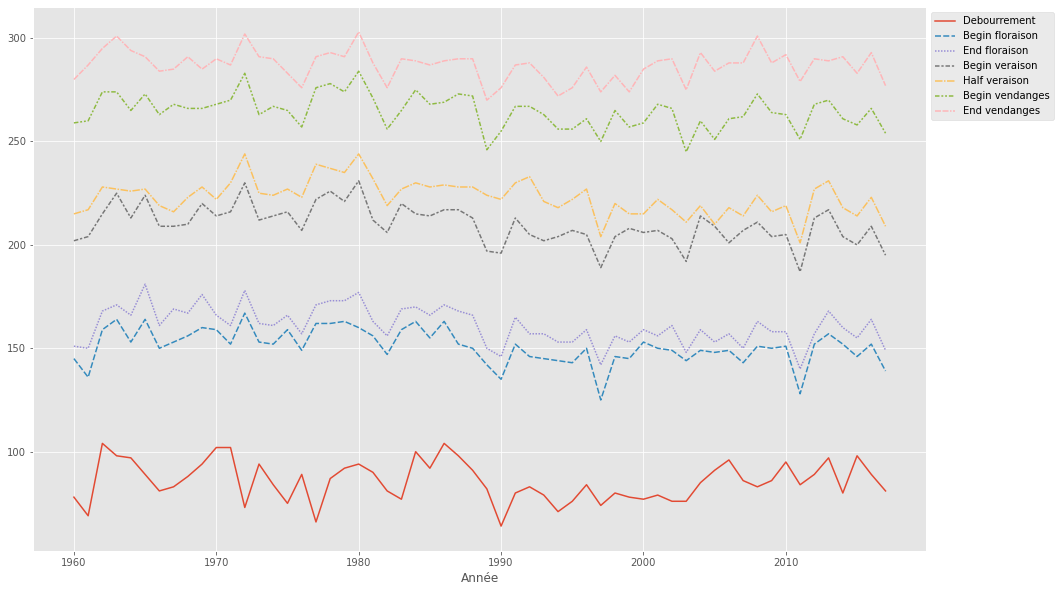

In [106]:
pheno_1 = pheno_1.loc[1960:2017]
pheno_2 = pheno_2.loc[1960:2017]

pheno_df = pd.DataFrame(np.zeros(len(pheno_1)), index = pheno_1.index).iloc[:, 1:]

### Debourrement
# Calculate mean
pheno_df['Debourrement'] = pheno_1['Source 1: debourrement'] + (pheno_2['Source 2: debourrement'] - pheno_1['Source 1: debourrement'])/2
# Fill missing values with either only source 1 or only source 2
pheno_df['Debourrement'] = pheno_df['Debourrement'].fillna(pheno_2['Source 2: debourrement']).fillna(pheno_1['Source 1: debourrement']).dt.normalize()



### Floraison
pheno_df['Begin floraison'] = pheno_1['Source 1: begin floraison']

# For the end: get the later known date between end floraison and half-floraison
pheno_df['End floraison'] = np.nan
for year in pheno_df.index[1:]:
    date_1 = pheno_1.loc[year, 'Source 1: end floraison']
    date_2 = pheno_2.loc[year, 'Source 2: half-floraison']
    pheno_df.loc[year, 'End floraison'] = max(date_1, date_2)
pheno_df['End floraison'] = pheno_df['End floraison'].fillna(pheno_1['Source 1: end floraison'])\
                                                     .fillna(pheno_2['Source 2: half-floraison'])\
                                                     .dt.normalize()
    
### Veraison
average_veraison_delay = np.mean(pheno_2['Source 2: half-veraison'] - pheno_1['Source 1: begin veraison'])
pheno_df['Begin veraison'] = pheno_1['Source 1: begin veraison'].fillna(pheno_2['Source 2: half-veraison'] - average_veraison_delay).dt.normalize()
pheno_df['Half veraison'] = pheno_2['Source 2: half-veraison']
pheno_df['Half veraison'] = pheno_df['Half veraison'].fillna(pheno_1['Source 1: begin veraison'] + average_veraison_delay).dt.normalize()


### Vendanges
# For the begin: get the earliest known date between the two sources
pheno_df['Begin vendanges'] = pheno_1.loc[year, 'Source 1: begin of the first vendanges']
for year in pheno_df.index[1:]:
    date_1 = pheno_1.loc[year, 'Source 1: begin of the first vendanges']
    date_2 = pheno_2.loc[year, 'Source 2: begin vendanges']
    pheno_df.loc[year, 'Begin vendanges'] = min(date_1, date_2)
pheno_df['Begin vendanges'] = pheno_df['Begin vendanges'].fillna(pheno_1['Source 1: begin of the first vendanges'])\
                                                     .fillna(pheno_2['Source 2: begin vendanges'])\
                                                     .dt.normalize()
# For the end: get the later known date between the two sources
pheno_df['End vendanges'] = np.nan
for year in pheno_df.index[1:]:
    date_1 = pheno_1.loc[year, 'Source 1: end vendanges']
    date_2 = pheno_2.loc[year, 'Source 2: end vendanges']
    pheno_df.loc[year, 'End vendanges'] = max(date_1, date_2)
pheno_df['End vendanges'] = pheno_df['End vendanges'].fillna(pheno_1['Source 1: end vendanges'])\
                                                     .fillna(pheno_2['Source 2: end vendanges'])\
                                                     .dt.normalize()


display(pheno_df.info())
pheno_df_plot = pheno_df.copy()
for col in pheno_df_plot.columns:
    pheno_df_plot[col] = pheno_df_plot[col].dt.dayofyear
plt.figure(figsize=(16,10))
palette = sns.color_palette('viridis', 6)
sns.lineplot(data=pheno_df_plot)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig('views/pheno_full.png')
plt.show()

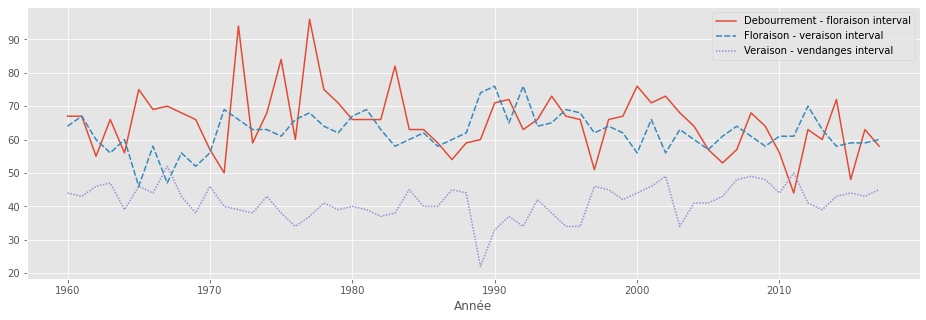

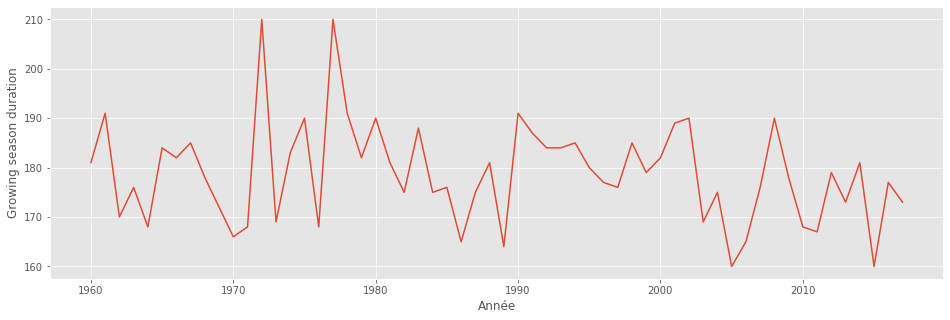

In [110]:
pheno_df['Debourrement - floraison interval'] = (pheno_df['Begin floraison'] - pheno_df['Debourrement']).dt.days
pheno_df['Floraison - veraison interval'] = (pheno_df['Half veraison'] - pheno_df['End floraison']).dt.days
pheno_df['Veraison - vendanges interval'] = (pheno_df['Begin vendanges'] - pheno_df['Half veraison']).dt.days
pheno_df['Growing season duration'] = (pheno_df['Begin vendanges'] - pheno_df['Debourrement']).dt.days
sns.lineplot(data=pheno_df.iloc[:, -4:-1])
plt.show()

sns.lineplot(data=pheno_df.iloc[:, -1])
plt.show()
pheno_df.to_excel('data/generated_pheno.xlsx')